# Advanced Mesh Composition 

In [1]:
from dewloosh.mesh import PolyData, grid
from dewloosh.mesh.space import StandardFrame, PointCloud
from dewloosh.mesh.utils import centralize, center_of_points
from dewloosh.math.linalg import linspace
from dewloosh.mesh.tri import triangulate
from dewloosh.mesh.tri.triutils import get_points_inside_triangles
from dewloosh.mesh.topo import remap_topo, nodal_adjacency
from sectionproperties.pre.library.steel_sections import circular_hollow_section as CHS
from sectionproperties.pre.library.steel_sections import rectangular_hollow_section as RHS
from sectionproperties.pre.library.steel_sections import i_section
import numpy as np
import awkward as ak

In [2]:
from sectionproperties.pre.pre import Material
steel = Material(
    name='Steel', elastic_modulus=200e3, poissons_ratio=0.3, density=7.85e-6,
    yield_strength=250, color='grey'
)

In [3]:
database = {
    'left' : {
        'geom' : CHS(d=100, t=10, n=64),
        'support' : True},
    'right' : {
        'geom' : CHS(d=100, t=10, n=64),
        'support' : True},
    'front' : {
        'geom' : RHS(d=100, b=100, t=10, r_out=0, n_r=0, material=steel),
        'dynams' : {'N' : 1e+6, 'Vx' : 0., 'Vy' : 0, 
                    'T' : 0.,  'Mx' : 0, 'My' : 0.}},
    'back' : {
        'geom' : RHS(d=100, b=100, t=10, r_out=0, n_r=0, material=steel),
        'dynams' : {'N' : 0., 'Vx' : 0., 'Vy' : 0, 
                    'T' : 5e+7,  'Mx' : 0, 'My' : 0.}},
    'top' : {
        'geom' : i_section(d=170, b=110, t_f=7.8, t_w=5.8, r=8.9, n_r=16, material=steel),
        'dynams' : {'N' : 0., 'Vx' : 1e+4, 'Vy' : 0, 
                    'T' : 0,  'Mx' : 0, 'My' : 0.}}
}

In [4]:
Lx, Ly, Lz = 220, 220, 220
points_per_edge = 25
mesh_size = Lx / (points_per_edge-1)

In [5]:
points = []  # storage for coordinates
nTotalPoints = 0  # node counter

# corners
corner_coords = [
    [-Lx/2, -Ly/2, -Lz/2],
    [Lx/2, -Ly/2, -Lz/2],
    [Lx/2, Ly/2, -Lz/2],
    [-Lx/2, Ly/2, -Lz/2],
    [-Lx/2, -Ly/2, Lz/2],
    [Lx/2, -Ly/2, Lz/2],
    [Lx/2, Ly/2, Lz/2],
    [-Lx/2, Ly/2, Lz/2]
]
corner_coords = np.array(corner_coords)
points.append(corner_coords)
nTotalPoints += len(corner_coords)

# populate edges
nodes_of_edges = [
    [0, 1], [1, 2], [2, 3], [3, 0],
    [4, 5], [5, 6], [6, 7], [7, 4],
    [0, 4], [1, 5], [2, 6], [3, 7]
    ]
edge_coords = []
N = points_per_edge + 2
for nodes in nodes_of_edges:
    p0 = corner_coords[nodes[0]]
    p1 = corner_coords[nodes[1]]
    edge_coords.append(linspace(p0, p1, N)[1:-1])
edge_coords = np.vstack(edge_coords)
points.append(edge_coords)
nTotalPoints += len(edge_coords)

# faces
corners_of_faces = {
    'front' : [1, 2, 6, 5], 
    'back' : [0, 3, 7, 4], 
    'left' : [2, 3, 7, 6],  
    'right' : [0, 1, 5, 4],
    'bottom' : [0, 1, 2, 3], 
    'top' : [4, 5, 6, 7],  
}
edges_of_faces = {
    'front' : [1, 5, 9, 10], 
    'back' : [3, 7, 8, 11], 
    'right' : [0, 9, 4, 8],  
    'left' : [2, 6, 10, 11],
    'bottom' : [0, 1, 2, 3], 
    'top' : [4, 5, 6, 7],  
}

# center of face
def cof(id) : return center_of_points(corner_coords[corners_of_faces[id]])

# face frames
frames = {}
GlobalFrame = StandardFrame(dim=3)
frames['front'] = GlobalFrame.fork().move(cof('front'))
rot90z = 'Body', [0, 0, np.pi/2], 'XYZ'
frames['left'] = frames['front'].fork(*rot90z).move(cof('left') - cof('front'))
frames['back'] = frames['left'].fork(*rot90z).move(cof('back') - cof('left'))
frames['right'] = frames['back'].fork(*rot90z).move(cof('right') - cof('back'))
rot_front_top = 'Body', [0, -np.pi/2, 0], 'XYZ'
frames['top'] = frames['front'].fork(*rot_front_top).move(cof('top') - cof('front'))
rot180y = 'Body', [0, np.pi, 0], 'XYZ'
frames['bottom'] = frames['top'].fork(*rot180y).move(cof('bottom') - cof('top'))

In [6]:
coords_grid, topo_grid = grid(size=(Lx*0.99, Ly*0.99), shape=(N, N), 
                              eshape='Q4', centralize=True)
Grid = PolyData(coords=coords_grid, topo=topo_grid, frame=GlobalFrame)
grid_centers = Grid.centers()[:, :2]

In [7]:
for face in frames:
    
    f_frame = frames[face]    
    # collect points on corners and edges and their global indices
    # these indices are used later to remap the default topology
    # resulting from per-face triangulations
    f_coords_base = []
    f_inds_base = []
    _corner_inds = []
    for corner in corners_of_faces[face]:
        f_coords_base.append(corner_coords[corner])
        _corner_inds.append(corner)
    f_inds_base.append(np.array(_corner_inds, dtype=int))
    for edge in edges_of_faces[face]:
        inds = np.arange(points_per_edge) + edge * points_per_edge
        f_coords_base.append(edge_coords[inds])
        f_inds_base.append(inds + 8)
    f_coords_base = np.vstack(f_coords_base)
        
    # transform the coords (base coordinates) so far to face frame    
    f_coords_base = PointCloud(f_coords_base, frame=GlobalFrame).show(f_frame)    
    
    # global indices and number of corner and edge points
    f_inds_base = np.concatenate(f_inds_base)
    nBasePoints = len(f_inds_base)
    
    # build face    
    if face in database:
        # 1) create the mesh of the section
        # 2) rule out points of the base grid that the section covers
        # 3) add corner and edge nodes and do a triangulation
        #----
        # get the mesh of the actual section 
        f_section = database[face]['geom']
        f_section.create_mesh(mesh_sizes=[20.])
        f_coords_s = centralize(np.array(f_section.mesh['vertices']))
        n_section_nodes = f_coords_s.shape[0]
        f_topo_s = np.array(f_section.mesh['triangles'].tolist())[:, :3]
        # get rid of points overlapped by the section
        f_inds = get_points_inside_triangles(f_coords_s, f_topo_s, grid_centers).astype(bool)      
        f_coords = np.vstack([f_coords_base[:, 1:], f_coords_s, grid_centers[~f_inds]])     
        # final triangulation of the face
        f_coords, f_topo, _ = triangulate(points=f_coords)        
    else:
        f_coords = np.vstack([f_coords_base[:, 1:], grid_centers])
        f_coords, f_topo, _ = triangulate(points=f_coords)
        s_inds = None
               
    # faces share some points, hence they must be consistent
    # in node numbering --> remap topology to match indices
    # of corner and edge nodes
    f_inds = np.zeros(len(f_coords), dtype=int)
    nNewPoints = len(f_coords) - nBasePoints
    f_inds[:nBasePoints] = f_inds_base
    f_inds[nBasePoints:] = np.arange(nNewPoints) + nTotalPoints
    nTotalPoints += nNewPoints
    f_topo = remap_topo(f_topo, f_inds)
    
    # transform to global and append new data to total collection
    f_coords_new = np.zeros((nNewPoints, 3))
    f_coords_new[:, 1:] = f_coords[nBasePoints:]
    f_coords = PointCloud(f_coords_new, frame=f_frame).show(GlobalFrame)
    points.append(f_coords)
       
    # add topology to face to total collection
    if face not in database:
        database[face] = {}
    database[face]['topo'] = f_topo

In [8]:
cubepoints = np.vstack(points)
nCubePoints = len(cubepoints)
cube = PolyData(coords=cubepoints, frame=GlobalFrame)
for face in frames:
    cube[face] = PolyData(topo=database[face]['topo'])

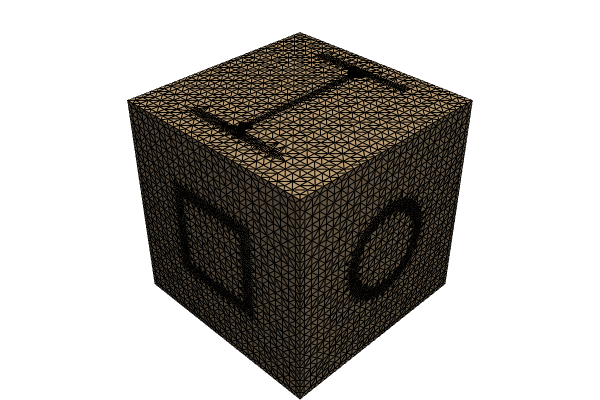

In [9]:
cube.pvplot(jupyter_backend='static', notebook=True, window_size=(600, 400))

Detach the top face and plot it:

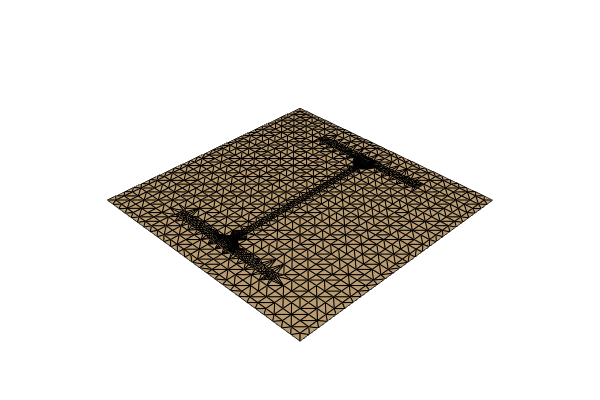

In [10]:
top = cube['top'].detach()
top.pvplot(jupyter_backend='static', notebook=True, window_size=(600, 400))

We can also plot trinagulated surfaces using the goodies in ``dewloosh.mesh.tri``:

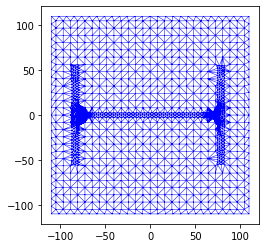

In [11]:
from dewloosh.mesh.tri import triplot, triangulate
points = top.points().show(top.frame)
triangles = top.topology()
triobj = triangulate(points=points[:, :2], triangles=triangles)[-1]
triplot(triobj)